<a href="https://colab.research.google.com/github/filippomenegatti/NeuralNetwork_ClassificationProj/blob/main/ML_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification with Neural Networks
Use `tensorflow` to train neural networks for the classification of fruit/vegetable types based on images from this dataset. Images must be transformed from JPG to RGB pixel values and scaled down (e.g., 32x32).  
Use fruit/vegetable types (as opposed to variety) as labels to predict and consider only the 10 most frequent types (apple, banana, plum, pepper, cherry, grape, tomato, potato, pear, peach).  
Experiment with different network architectures and training parameters documenting their influence of the final predictive performance. While the training loss can be chosen freely, the reported test errors must be measured according to the zero-one loss for multiclass classification.

In [ ]:
from google.colab import files

files.upload() #import the kaggle.json file

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d moltean/fruits
!mkdir ML_assignment
!unzip fruits.zip -d ML_assignment

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers
from keras.callbacks import LearningRateScheduler, History, EarlyStopping

## Import of the dataset

In [ ]:
file_path = '/content/ML_assignment/fruits-360'

In [ ]:
types = ["Apple", "Banana", "Plum", "Pepper", "Cherry", "Grape", "Tomato", "Potato", "Pear", "Peach"]

fruits = {}

def load_dataset(dire):
    fruits = {}
    images_as_array = []
    labels =[]
    for category in os.listdir(dire):
        for typ in types:
            if(category.split()[0] == typ):
                fruits[category]= typ
                path = os.path.join(dire,category)
                class_num =types.index(fruits[category])

                class_name = fruits[category]
                for img in os.listdir(path):
                    file = os.path.join(path,img)
                    images_as_array.append(img_to_array(load_img(file,target_size=(32, 32))))
                    labels.append(class_num)
    images_as_array =  np.array(images_as_array)
    labels = np.array(labels)
    return images_as_array, labels

In [ ]:
train_path= '/content/ML_assignment/fruits-360/Training'
test_path= '/content/ML_assignment/fruits-360/Test'

In [ ]:
train = load_dataset(train_path)
test = load_dataset(test_path)

In [ ]:
X_train, y_train = train
X_test, y_test = test

In [ ]:
random.seed(33)

In [ ]:
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(32607, 32, 32, 3)
(10906, 32, 32, 3)


In [ ]:
n_classes = len(np.unique(y_train))
n_classes

10

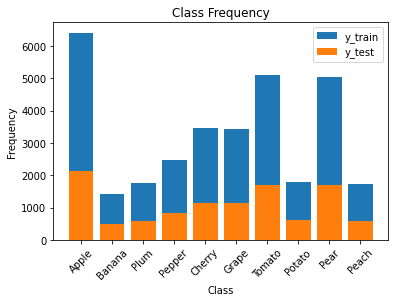

In [ ]:
#look at the distribution of the classes in the sets

unique, counts = np.unique(y_train, return_counts=True)
plt.bar(types, counts)

unique, counts = np.unique(y_test, return_counts=True)
plt.bar(types, counts)

plt.xticks(rotation=45)
plt.gca().legend(('y_train','y_test'))
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

In [ ]:
# create validation set from test set 75/25

In [ ]:
X_val, X_train, y_val, y_train  = train_test_split(X_train, y_train, train_size = 0.20)

In [ ]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
X_val = X_val.astype('float32')/255

In [ ]:
print('Training X:\n',X_train.shape)
print('\nVaildation X:\n',X_val.shape)
print('\nTest X:\n',X_test.shape)

Training X:
 (26086, 32, 32, 3)

Vaildation X:
 (6521, 32, 32, 3)

Test X:
 (10906, 32, 32, 3)


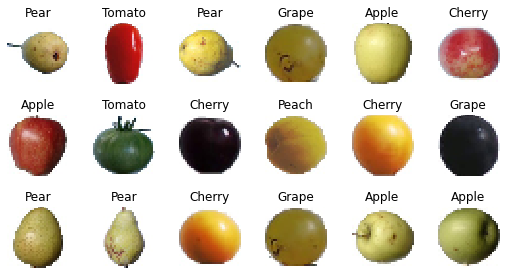

In [ ]:
n_rows = 3
n_cols = 6
plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(types[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [ ]:
y_train = np_utils.to_categorical(y_train, n_classes)
y_val = np_utils.to_categorical(y_val, n_classes)
y_test = np_utils.to_categorical(y_test, n_classes)

## 0-1 Loss Function

In [ ]:
def zo_loss(test, pred):
    y_hat = []
    y_t = []
    for i in range(len(pred)):
        y_hat.append(np.argmax(pred[i]))
        y_t.append(np.argmax(test[i]))

   
    loss = []
    for i in range(len(pred)):
        if(y_hat[i] == y_t[i]):
            loss.append(0)
        else:
            loss.append(1)


    return np.mean(loss)

## First try model

Cross-entropy loss function:  
$ H(y,\hat{y}) =  -\sum_i y_i \log \hat{y_i} $

### Stochastic Gradient Descent

## Standard basic model

In [ ]:
tf.random.set_seed(33)

In [ ]:
model1 = keras.Sequential()
model1.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model1.add(keras.layers.Dense(230, activation="relu"))
model1.add(keras.layers.Dense(100, activation="relu"))
model1.add(keras.layers.Dense(10, activation="softmax"))

model1.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = "sgd",
              metrics = ["accuracy"])

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 230)               706790    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               23100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 730,900
Trainable params: 730,900
Non-trainable params: 0
_________________________________________________________________


Fitting of the model

In [ ]:
%%time

history1 = model1.fit(X_train, y_train, epochs=30,
                    validation_data=(X_val, y_val), verbose = 1,
                     callbacks = [EarlyStopping(monitor='val_accuracy', patience=2)])

In [ ]:
model1.evaluate(X_train, y_train)
model1.evaluate(X_test, y_test)

341/341 [==============================] - 1s 3ms/step - loss: 0.1832 - accuracy: 0.9443


[0.18316933512687683, 0.9443425536155701]

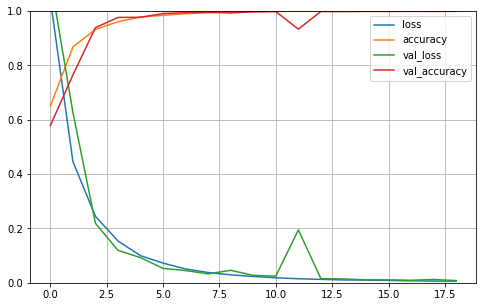

In [ ]:
pd.DataFrame(history1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
y_pred1 = model1.predict(X_test)
zo_loss(y_test, y_pred1)

0.055657436273610854

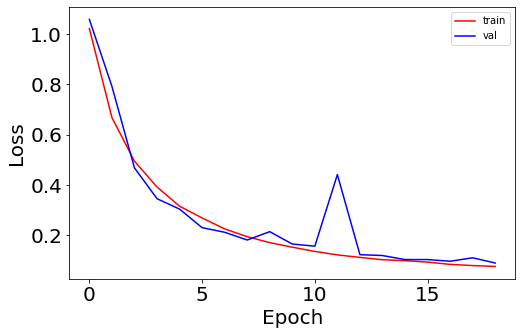

In [ ]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(np.sqrt(history1.history['loss']), 'r', label='train')
ax.plot(np.sqrt(history1.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

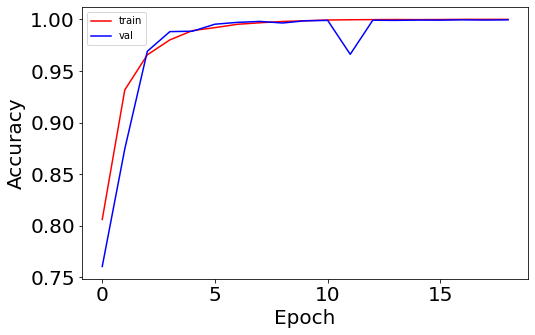

In [ ]:
# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(np.sqrt(history1.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(history1.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

The batch size defines the number of samples that will be propagated through the network.  
For instance, let’s say you have 1000 training samples and you want to set up a batch_size equal to 100. The algorithm takes the first 100 samples (from 1st to 100th) from the training dataset and trains the network. Next, it takes the second 100 samples (from 101st to 200th) and trains the network again. We can keep doing this procedure until we have propagated all samples through the network.

The number of epochs is a hyperparameter that defines the number times that the learning algorithm will work through the entire training dataset. One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters. An epoch is comprised of one or more batches.

In [ ]:
# define the learning rate change 
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate

In [ ]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=2)
epochs = 30
decay_rate = 1e-6
momentum = 0.9
learning_rate = 0.01
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [loss_history, lr_rate, early_stop]

model2 = keras.Sequential()
model2.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model2.add(keras.layers.Dense(230, activation="relu"))
#model2.add(keras.layers.Dense(100, activation="relu"))
model2.add(keras.layers.Dense(10, activation="softmax"))

model2.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = sgd,
              metrics = ["accuracy"])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 230)               706790    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2310      
Total params: 709,100
Trainable params: 709,100
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time

model2_history = model2.fit(X_train, y_train, epochs=epochs, 
                            verbose=1, callbacks=callbacks_list,
                            validation_data=(X_val, y_val))

Epoch 1/30
816/816 [==============================] - 5s 5ms/step - loss: 0.9781 - accuracy: 0.6715 - val_loss: 1.1249 - val_accuracy: 0.7806
Epoch 2/30
816/816 [==============================] - 4s 5ms/step - loss: 0.1671 - accuracy: 0.9488 - val_loss: 0.0817 - val_accuracy: 0.9727
Epoch 3/30
816/816 [==============================] - 4s 5ms/step - loss: 0.0695 - accuracy: 0.9779 - val_loss: 0.0273 - val_accuracy: 0.9940
Epoch 4/30
816/816 [==============================] - 4s 5ms/step - loss: 0.0326 - accuracy: 0.9905 - val_loss: 0.0433 - val_accuracy: 0.9845
Epoch 5/30
816/816 [==============================] - 4s 5ms/step - loss: 0.0259 - accuracy: 0.9922 - val_loss: 0.0128 - val_accuracy: 0.9965
Epoch 6/30
816/816 [==============================] - 4s 5ms/step - loss: 0.0144 - accuracy: 0.9960 - val_loss: 0.0045 - val_accuracy: 0.9994
Epoch 7/30
816/816 [==============================] - 4s 5ms/step - loss: 0.0042 - accuracy: 0.9995 - val_loss: 0.0060 - val_accuracy: 0.9992
Epoch 

In [ ]:
model2.evaluate(X_train, y_train)
model2.evaluate(X_test, y_test)

341/341 [==============================] - 1s 2ms/step - loss: 0.1962 - accuracy: 0.9498


[0.19624514877796173, 0.9498441219329834]

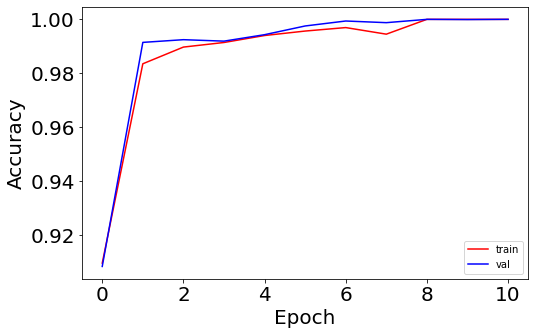

In [ ]:
# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.plot(np.sqrt(model2_history.history['accuracy']), 'r', label='train')
ax.plot(np.sqrt(model2_history.history['val_accuracy']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [ ]:
y_pred2 = model2.predict(X_test)
zo_loss(y_test, y_pred2)

0.03585182468366037

Next we will try to change the setup adding regularization terms to the first setup.  

### Dropout  
At every iteration, it randomly selects some nodes - given a certain probability - and removes them along with all of their incoming and outgoing connections.

In [ ]:
model4 = keras.Sequential()
model4.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model4.add(keras.layers.Dense(230, activation="relu"))
model4.add(keras.layers.Dropout(0.2))
model4.add(keras.layers.Dense(100, activation="relu"))
model4.add(keras.layers.Dropout(0.2))
model4.add(keras.layers.Dense(10, activation="softmax"))

model4.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = "sgd",
              metrics = ["accuracy"])

model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 230)               706790    
_________________________________________________________________
dropout (Dropout)            (None, 230)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               23100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1010      
Total params: 730,900
Trainable params: 730,900
Non-trainable params: 0
________________________________________________

In [ ]:
%%time

history4 = model4.fit(X_train, y_train, epochs=30,
                      validation_data=(X_val, y_val), verbose = 1,
                      callbacks = [EarlyStopping(monitor='val_accuracy', patience=2)])

In [ ]:
print(model4.evaluate(X_train, y_train))
print(model4.evaluate(X_test, y_test))

816/816 [==============================] - 2s 3ms/step - loss: 0.0095 - accuracy: 0.9986
[0.009461662732064724, 0.99858158826828]
341/341 [==============================] - 1s 3ms/step - loss: 0.1924 - accuracy: 0.9350
[0.19243223965168, 0.9349899291992188]


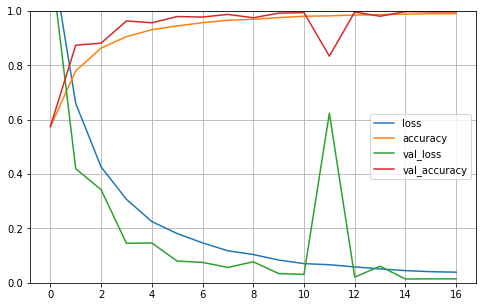

0.06501008619108747

In [ ]:
pd.DataFrame(history4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

y_pred4 = model4.predict(X_test)
zo_loss(y_test, y_pred4)

Adding the dropout in the final layer slightly improved the model accuracy.

In [ ]:
model5 = keras.Sequential()
model5.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model5.add(keras.layers.Dense(230, activation="relu", kernel_regularizer=regularizers.l2(1e-4)))
model5.add(keras.layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l2(1e-4)))
model5.add(keras.layers.Dense(10, activation="softmax"))

model5.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = "sgd",
              metrics = ["accuracy"])

model5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 230)               706790    
_________________________________________________________________
dense_16 (Dense)             (None, 100)               23100     
_________________________________________________________________
dense_17 (Dense)             (None, 10)                1010      
Total params: 730,900
Trainable params: 730,900
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time

history5 = model5.fit(X_train, y_train, epochs=30,
                      validation_data=(X_val, y_val), verbose = 1,
                      callbacks = [EarlyStopping(monitor='val_accuracy', patience=2)])

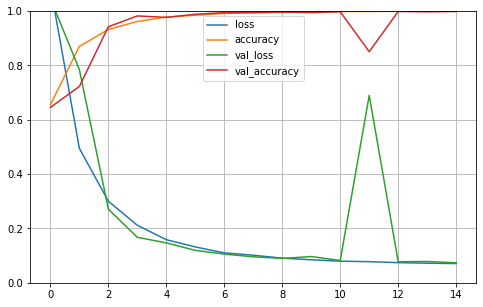

816/816 [==============================] - 3s 3ms/step - loss: 0.0689 - accuracy: 0.9997
[0.06891285628080368, 0.9997316598892212]
341/341 [==============================] - 1s 3ms/step - loss: 0.2337 - accuracy: 0.9398
[0.23372185230255127, 0.9397579431533813]
0.060242068586099394


In [ ]:
pd.DataFrame(history5.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

print(model5.evaluate(X_train, y_train))
print(model5.evaluate(X_test, y_test))

y_pred5 = model5.predict(X_test)
print(zo_loss(y_test, y_pred5))

## ADAM optimizer

In [ ]:
model6 = keras.Sequential()
model6.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model6.add(keras.layers.Dense(230, activation="relu", kernel_regularizer=regularizers.l2(1e-4)))
model6.add(keras.layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l2(1e-4)))
model6.add(keras.layers.Dense(10, activation="softmax"))

model6.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = "Adam",
              metrics = ["accuracy"])

model6.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 230)               706790    
_________________________________________________________________
dense_19 (Dense)             (None, 100)               23100     
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1010      
Total params: 730,900
Trainable params: 730,900
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time

history6 = model6.fit(X_train, y_train, epochs=30,
                      validation_data=(X_val, y_val), verbose = 1,
                      callbacks = [EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/30
816/816 [==============================] - 8s 9ms/step - loss: 1.0022 - accuracy: 0.6722 - val_loss: 0.3309 - val_accuracy: 0.9032
Epoch 2/30
816/816 [==============================] - 7s 9ms/step - loss: 0.2047 - accuracy: 0.9476 - val_loss: 0.1355 - val_accuracy: 0.9730
Epoch 3/30
816/816 [==============================] - 7s 9ms/step - loss: 0.1154 - accuracy: 0.9784 - val_loss: 0.0997 - val_accuracy: 0.9814
Epoch 4/30
816/816 [==============================] - 7s 9ms/step - loss: 0.1275 - accuracy: 0.9726 - val_loss: 0.0738 - val_accuracy: 0.9942
Epoch 5/30
816/816 [==============================] - 8s 9ms/step - loss: 0.0971 - accuracy: 0.9853 - val_loss: 0.1037 - val_accuracy: 0.9822
Epoch 6/30
816/816 [==============================] - 8s 9ms/step - loss: 0.1073 - accuracy: 0.9817 - val_loss: 0.1107 - val_accuracy: 0.9821
CPU times: user 1min 10s, sys: 3.16 s, total: 1min 13s
Wall time: 45.6 s


In [ ]:
print(model6.evaluate(X_train, y_train))
print(model6.evaluate(X_test, y_test))

816/816 [==============================] - 3s 4ms/step - loss: 0.1004 - accuracy: 0.9842
[0.10042210668325424, 0.984167754650116]
341/341 [==============================] - 1s 4ms/step - loss: 0.3085 - accuracy: 0.9126
[0.3084639310836792, 0.9126169085502625]


In [ ]:
y_pred6 = model6.predict(X_test)
print(zo_loss(y_test, y_pred6))

0.08738309187603155


Just one hidden layer

In [ ]:
model7 = keras.Sequential()
model7.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model7.add(keras.layers.Dense(200, activation="relu", kernel_regularizer=regularizers.l2(1e-4)))
model7.add(keras.layers.Dense(10, activation="softmax"))

model7.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = "Adam",
              metrics = ["accuracy"])

model7.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 200)               614600    
_________________________________________________________________
dense_22 (Dense)             (None, 10)                2010      
Total params: 616,610
Trainable params: 616,610
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time

history67 = model7.fit(X_train, y_train, epochs=30,
                      validation_data=(X_val, y_val), verbose = 1,
                      callbacks = [EarlyStopping(monitor='val_accuracy', patience=2)])

Epoch 1/30
816/816 [==============================] - 7s 8ms/step - loss: 0.7256 - accuracy: 0.7726 - val_loss: 0.2786 - val_accuracy: 0.9296
Epoch 2/30
816/816 [==============================] - 6s 8ms/step - loss: 0.2278 - accuracy: 0.9425 - val_loss: 0.1419 - val_accuracy: 0.9687
Epoch 3/30
816/816 [==============================] - 6s 7ms/step - loss: 0.1543 - accuracy: 0.9629 - val_loss: 0.1053 - val_accuracy: 0.9814
Epoch 4/30
816/816 [==============================] - 6s 8ms/step - loss: 0.1042 - accuracy: 0.9817 - val_loss: 0.1752 - val_accuracy: 0.9520
Epoch 5/30
816/816 [==============================] - 6s 8ms/step - loss: 0.0914 - accuracy: 0.9852 - val_loss: 0.1291 - val_accuracy: 0.9686
CPU times: user 47 s, sys: 2.43 s, total: 49.4 s
Wall time: 31.3 s


In [ ]:
print(model7.evaluate(X_train, y_train))
print(model7.evaluate(X_test, y_test))

816/816 [==============================] - 2s 3ms/step - loss: 0.1199 - accuracy: 0.9732
[0.1199173778295517, 0.9732040166854858]
341/341 [==============================] - 1s 3ms/step - loss: 0.4778 - accuracy: 0.8581
[0.4778215289115906, 0.8580597639083862]


In [ ]:
y_pred7 = model7.predict(X_test)
print(zo_loss(y_test, y_pred7))

0.14194021639464516


## Tuning?

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
def create_model(init_mode='uniform', optimizer = 'adam'):
    # define model
    model = Sequential()
    model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
    model.add(Dense(230, kernel_initializer=init_mode, activation=tf.nn.relu)) 
    model.add(Dense(10, kernel_initializer=init_mode, activation=tf.nn.softmax))
    # compile model
    model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])
    return model

In [ ]:
epochs = 30

model_CV = KerasClassifier(build_fn=create_model, epochs=epochs, verbose=1)

# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 
             'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

optimizer = ['sgd', 'adam', 'rmsprop']

param_grid = dict(init_mode=init_mode, optimizer=optimizer)
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, cv=5)
grid_result = grid.fit(X_train, y_train, callbacks=callbacks_list,
                            validation_data=(X_val, y_val))

In [ ]:
# print results
print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for 0.988997733592987 using {'init_mode': 'he_normal', 'optimizer': 'sgd'}
 mean=0.9417, std=0.03161 using {'init_mode': 'uniform', 'optimizer': 'sgd'}
 mean=0.7414, std=0.1096 using {'init_mode': 'uniform', 'optimizer': 'adam'}
 mean=0.4876, std=0.1482 using {'init_mode': 'uniform', 'optimizer': 'rmsprop'}
 mean=0.9664, std=0.01953 using {'init_mode': 'lecun_uniform', 'optimizer': 'sgd'}
 mean=0.5636, std=0.06311 using {'init_mode': 'lecun_uniform', 'optimizer': 'adam'}
 mean=0.4892, std=0.03086 using {'init_mode': 'lecun_uniform', 'optimizer': 'rmsprop'}
 mean=0.9802, std=0.01606 using {'init_mode': 'normal', 'optimizer': 'sgd'}
 mean=0.5686, std=0.1541 using {'init_mode': 'normal', 'optimizer': 'adam'}
 mean=0.4361, std=0.03765 using {'init_mode': 'normal', 'optimizer': 'rmsprop'}
 mean=0.1966, std=0.004865 using {'init_mode': 'zero', 'optimizer': 'sgd'}
 mean=0.1966, std=0.004865 using {'init_mode': 'zero', 'optimizer': 'adam'}
 mean=0.1966, std=0.004865 using {'init_

In [ ]:
tuned_model = keras.Sequential()
tuned_model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
tuned_model.add(keras.layers.Dense(230, kernel_initializer= 'he_normal',  activation="relu"))
tuned_model.add(keras.layers.Dense(10, kernel_initializer= 'he_normal', activation="softmax"))

tuned_model.compile(loss = keras.losses.categorical_crossentropy,
              optimizer = sgd,
              metrics = ["accuracy"])

tuned_model.summary()

Model: "sequential_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_127 (Flatten)        (None, 3072)              0         
_________________________________________________________________
dense_255 (Dense)            (None, 230)               706790    
_________________________________________________________________
dense_256 (Dense)            (None, 10)                2310      
Total params: 709,100
Trainable params: 709,100
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time

tuned_model_history = tuned_model.fit(X_train, y_train, epochs=epochs, 
                            verbose=1, callbacks=callbacks_list,
                            validation_data=(X_val, y_val))

Epoch 1/30
816/816 [==============================] - 5s 5ms/step - loss: 1.0026 - accuracy: 0.6643 - val_loss: 0.4820 - val_accuracy: 0.8252
Epoch 2/30
816/816 [==============================] - 4s 5ms/step - loss: 0.1644 - accuracy: 0.9460 - val_loss: 0.0985 - val_accuracy: 0.9656
Epoch 3/30
816/816 [==============================] - 4s 5ms/step - loss: 0.0679 - accuracy: 0.9802 - val_loss: 0.0474 - val_accuracy: 0.9867
Epoch 4/30
816/816 [==============================] - 4s 5ms/step - loss: 0.0403 - accuracy: 0.9881 - val_loss: 0.0461 - val_accuracy: 0.9844
Epoch 5/30
816/816 [==============================] - 4s 5ms/step - loss: 0.0321 - accuracy: 0.9899 - val_loss: 0.0083 - val_accuracy: 0.9983
Epoch 6/30
816/816 [==============================] - 4s 5ms/step - loss: 0.0159 - accuracy: 0.9953 - val_loss: 0.0076 - val_accuracy: 0.9982
Epoch 7/30
816/816 [==============================] - 4s 5ms/step - loss: 0.0081 - accuracy: 0.9982 - val_loss: 0.0076 - val_accuracy: 0.9988
Epoch 

In [ ]:
tuned_model.evaluate(X_train, y_train)
tuned_model.evaluate(X_test, y_test)

341/341 [==============================] - 1s 3ms/step - loss: 0.2113 - accuracy: 0.9454


[0.21134145557880402, 0.9454428553581238]

In [ ]:
y_pred_tun = tuned_model.predict(X_test)
zo_loss(y_test, y_pred_tun)

0.05455712451861361